# Preprocessing text-mining
Ce notebook explore les données ocr burtes afin d'en comprendre les principales caractéristiques. Il ne contient, en lui-meme, pas de résultat mais a permis d'identifier les pistes de traitements qui ont permis:
- de choisir d'utiliser les données ltdrwocr
- d'identifier les améliorations qui seront mises en oevre dans le notebook de preprocessing du texte (4.3)

In [10]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
if not project_root in [Path(p).resolve() for p in sys.path]:
    sys.path.append(str(project_root))

from src import PATHS

In [11]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# 1. Chargement des données

In [17]:
df = pd.read_parquet(PATHS.processed_data / "df_raw_ocr.parquet")\
    .join(pd.read_parquet(PATHS.metadata / "df_encoded_labels.parquet"))\
    .join(pd.read_parquet(PATHS.metadata / "df_data_sets.parquet"))
df.head()

,raw_ocr,label,data_set
document_id,,,
aaa06d00,"I\nVvtts Research, 5 (1986) 131-144\nElsevier\...",6,test
aaa08d00,"""i1AR-13-97 THU ]7t59 RKH PUBLIC RELATIONS FAX...",9,train
aaa09e00,l\nCOVINGTON &amp; BUFR'LING~\n1201 PENNSYLVAN...,11,val
aaa10c00,"Chaikin, Karen\nFrom: Chaikin, Karen\nSent: Tu...",2,train
aaa11d00,"a\n`..~.:r'\n\npgNbr=1\n~ ~ Vt+~/`rr\n_.,\na\n...",3,train


In [18]:
df.isna().sum()

raw_ocr     0
label       0
data_set    0
dtype: int64

Text(0.5, 0.98, 'Distributions des différents labels')

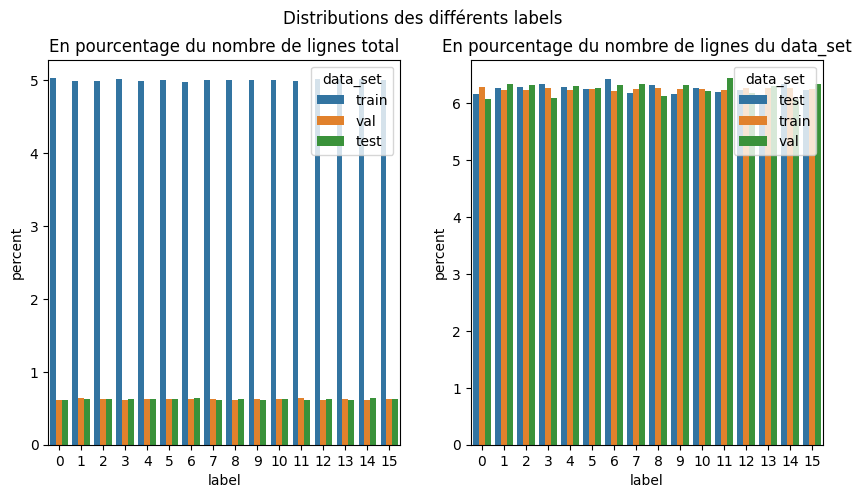

In [19]:
plt.figure(figsize =(10, 5))
plt.subplot(121)
sns.countplot(
    data = df,
    x = "label",
    hue = "data_set",
    stat="percent"

)
plt.title("En pourcentage du nombre de lignes total")
plt.subplot(122)

# je n'ai pas réussi à faire ce graphe avec seaborn nativement...
df_grouped = (
    df.groupby(["data_set", "label"])
    .size()
    .reset_index(name="count")
)
df_grouped["percent"] = df_grouped.groupby("data_set")["count"].transform(lambda x: x / x.sum() * 100)

sns.barplot(
    data=df_grouped,
    x="label",
    y="percent",
    hue="data_set"
)
plt.title("En pourcentage du nombre de lignes du data_set")
plt.suptitle("Distributions des différents labels")

In [20]:
train = df[df.data_set == "train"].drop(columns="data_set")
test = df[df.data_set == "test"].drop(columns="data_set")
val = df[df.data_set == "val"].drop(columns="data_set")

A partir de maintenant, nous ne travaillons que sur train

# 2. Etude manuelle des défauts d'OCR

In [21]:
# OPERATION PREALABLE // A RETIRER QUAND PROCESSUS STABLE

train = train[:1000]

In [22]:
# Pour faciliter les premières analyses, on va se limiter aux ocr dont le nombre de caractères n'est pas trop long:
train_short_ocrs = train[train.raw_ocr.str.len()<500]
# len(train_short_ocrs) @=197

In [32]:
# La fonction ocr_insight permet d'afficher une image et son texte océrisé côte à côte.
# Cela va nous permettre de mieux comprendre certains ocr
from PIL import Image
import io
import base64
from IPython.display import display, HTML

image_paths = PATHS.data / pd.read_parquet(
    PATHS.metadata / "df_filepaths.parquet")[["rvl_image_path", "iit_image_path"]]

def display_tiff_pages(tiff_path):
    img = Image.open(tiff_path)

    for i in range(img.n_frames):
        img.seek(i)  # Aller à la page i
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_b64 = base64.b64encode(buffered.getvalue()).decode()
        
        html_blocks.append(f'<img src="data:image/png;base64,{img_b64}" style="width: 60%; margin-bottom: 20px;" />')

    display(HTML("<br>".join(html_blocks)))




def get_image(document_id):
    """Return a BytesIO png converted image, which will be compatible with html display"""
    image_path = image_paths.loc[document_id, "iit_image_path"]
    
    html_blocks = []
    img = Image.open(image_path)
    
    for i in range(img.n_frames):
        img.seek(i)  # Aller à la page i
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_b64 = base64.b64encode(buffered.getvalue()).decode()
        
        html_blocks.append(f'<img src="data:image/png;base64,{img_b64}" />')
    return html_blocks
    
def ocr_insight(document_id):
    text = train.loc[document_id, "raw_ocr"]
    raw_text = repr(text)
    interpretated_text = '\n'.join([
        f"<p>{line}</p>"
        for line in text.splitlines()])
    image = get_image(document_id)
    
    html_code = f"""
    <div style="display: flex; align-items: center;">
      <div style="width: 40%; max-height: 600px; overflow-y: auto">
        <p><strong>Texte brut :</strong></p>
        <p>{raw_text}</p>
        <p><strong>Texte interprété :</strong></p>
        {interpretated_text}
      </div>
      <div style="width: 60%"; max-height: 600px>
        {"<br>".join(get_image(document_id))}
    </div>@
    </div>
    """
#      <img src="data:image/png;base64,{image}" style="width: 60%; margin-right: 20px;">
    display(HTML(html_code))


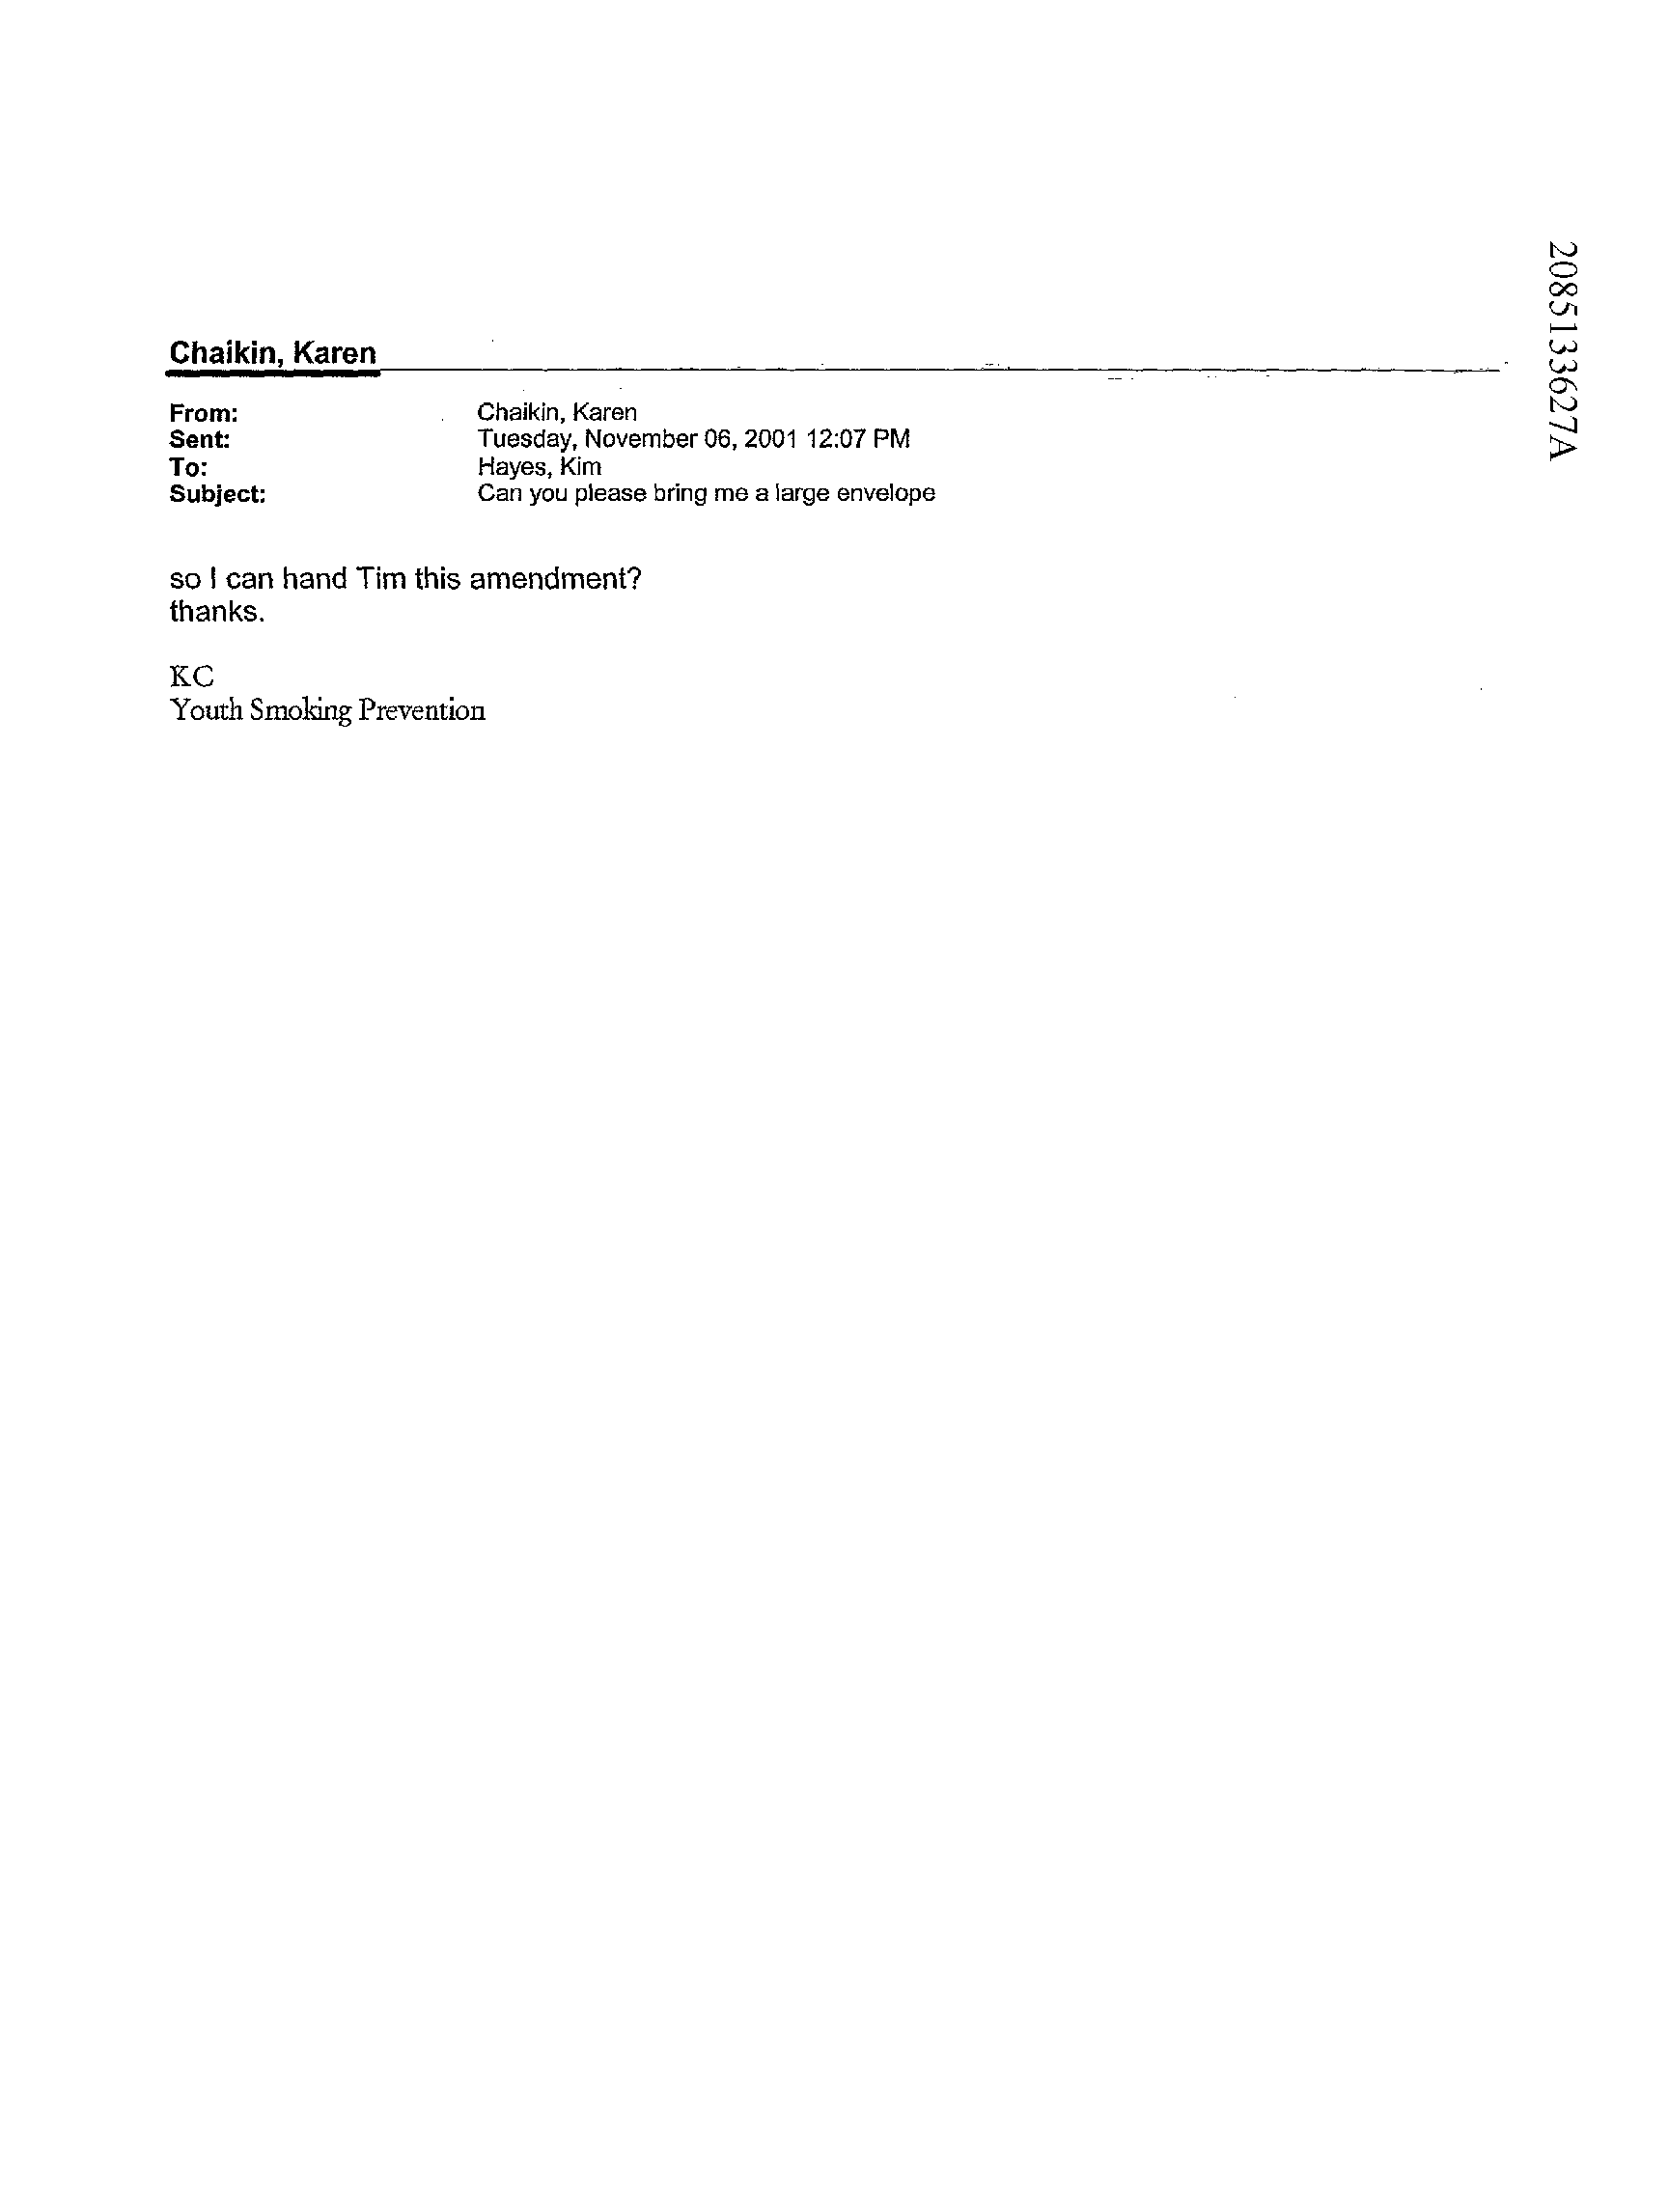

In [33]:
ocr_insight(train_short_ocrs.index[0])


<span style="color:blue">**Analyse :**</span>
- pgNbr inutile
- une typo (6ring qui est sans doute bring)


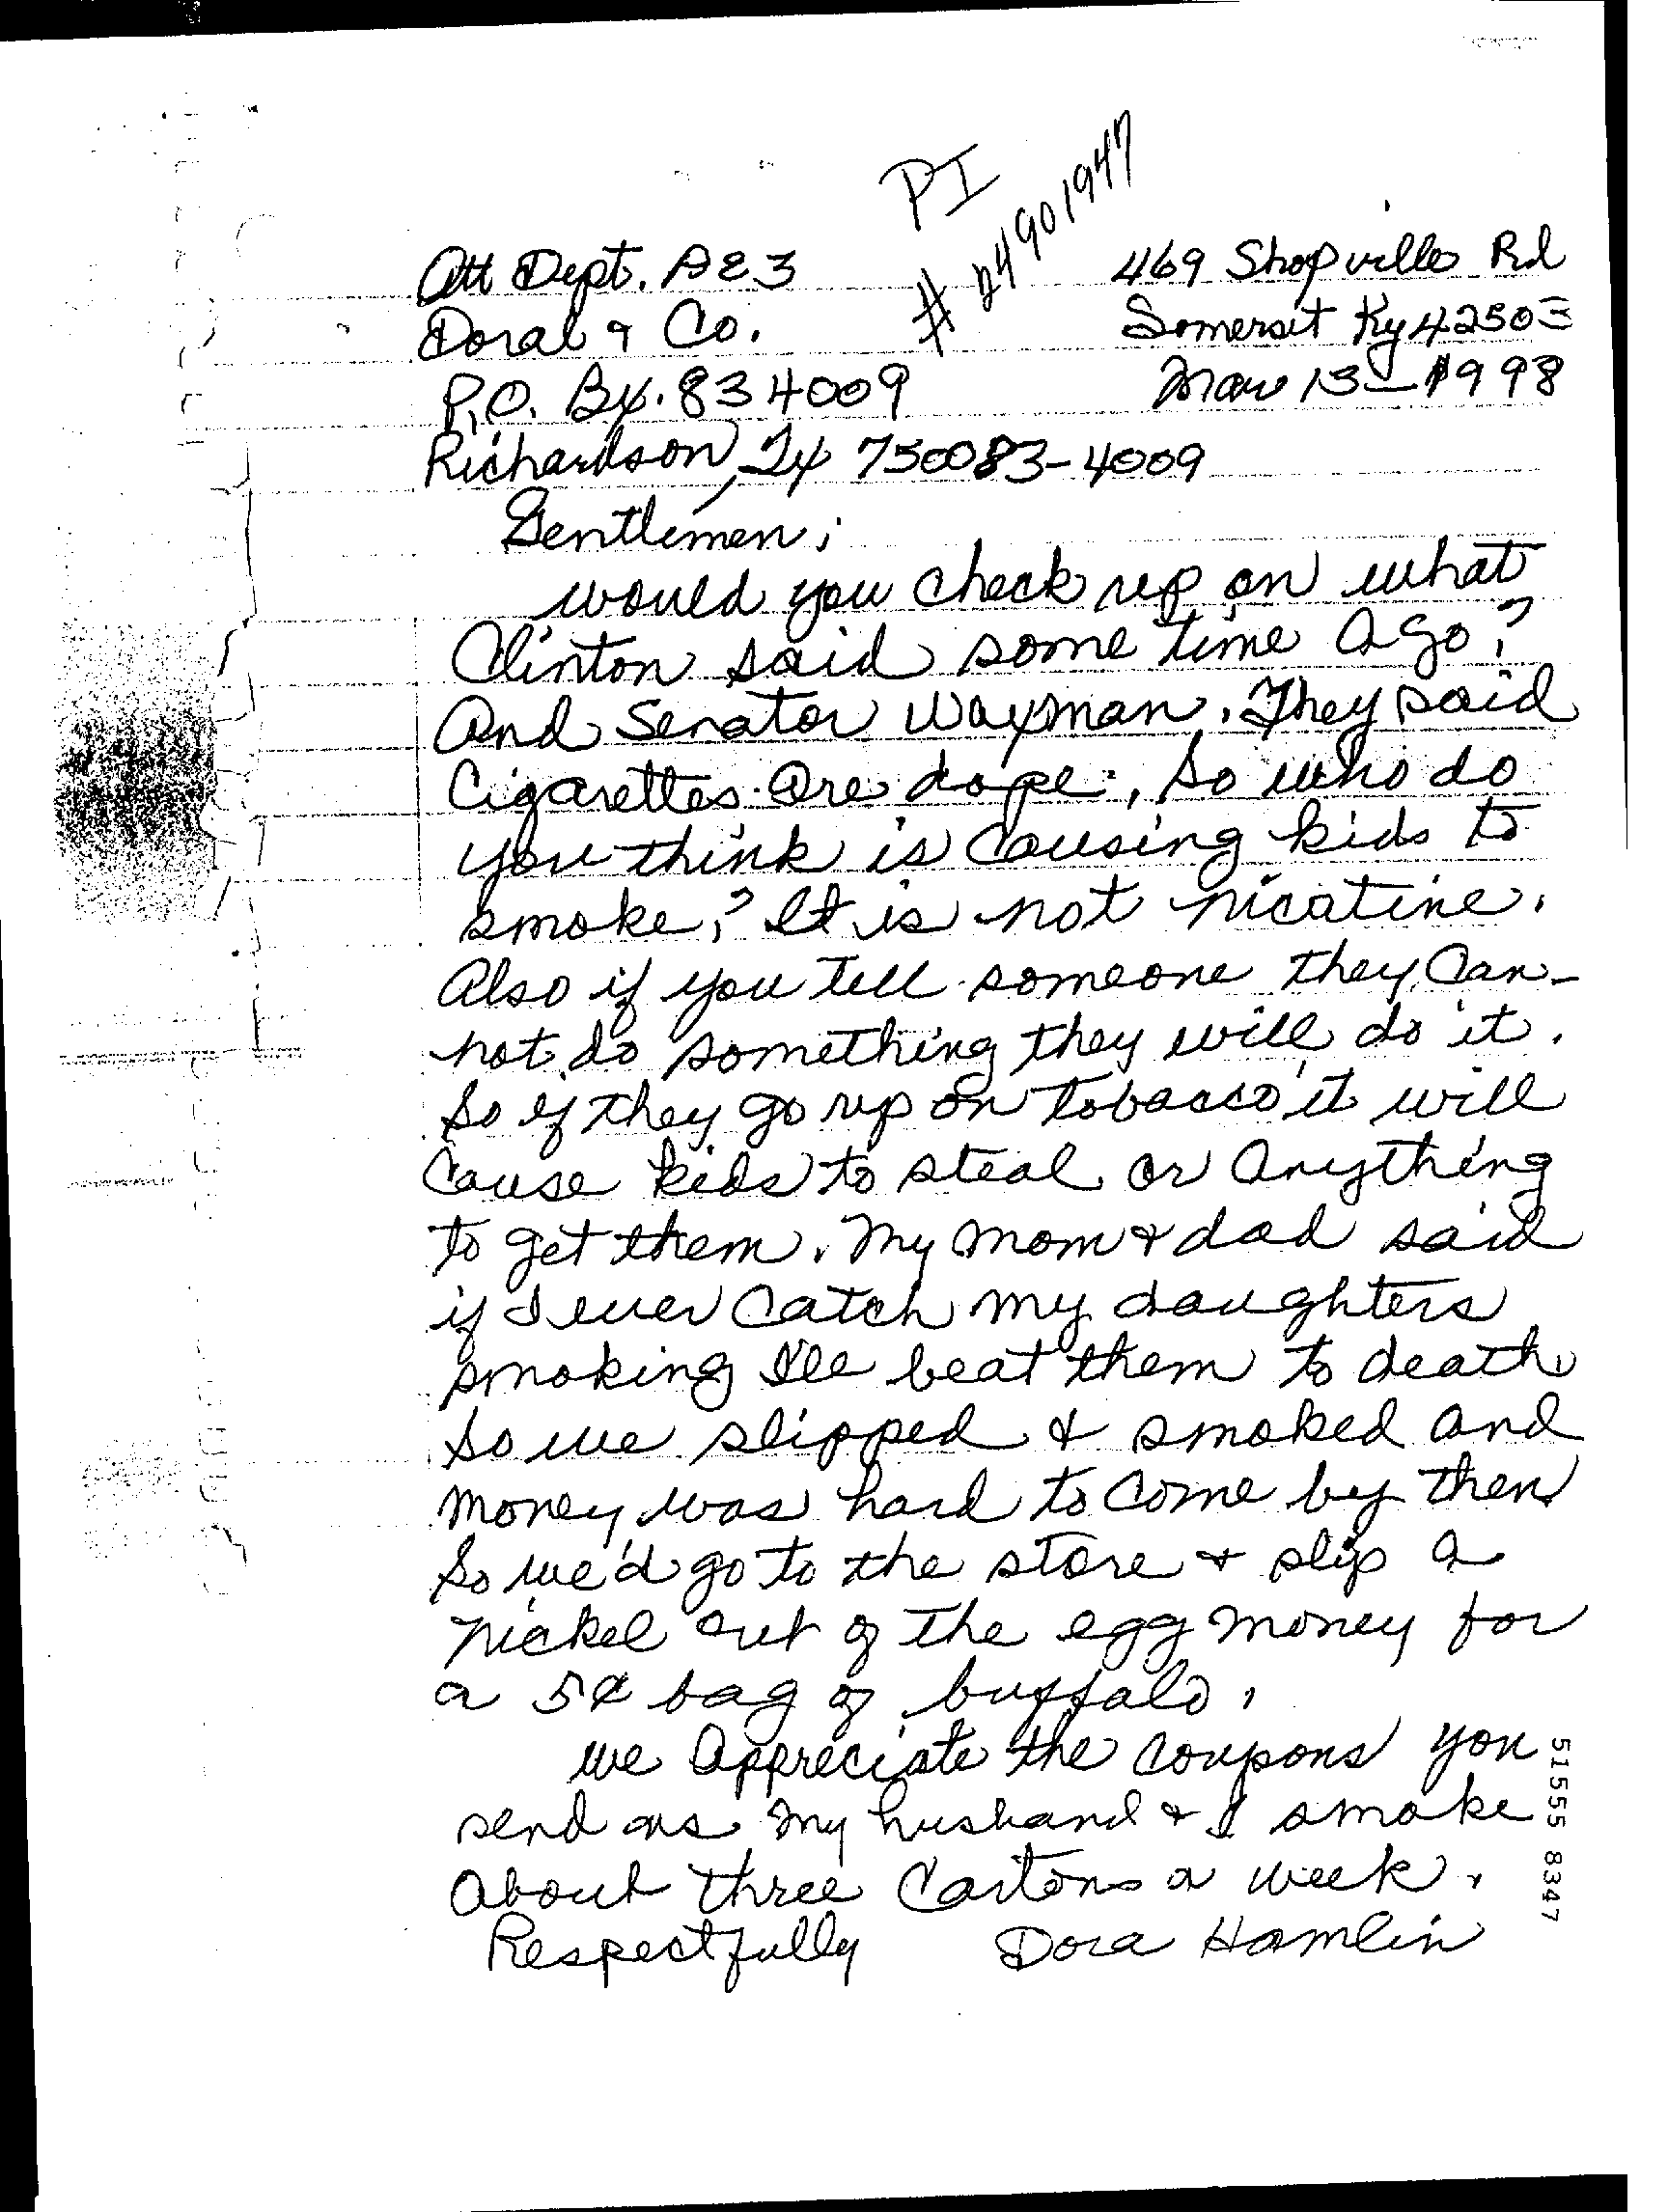
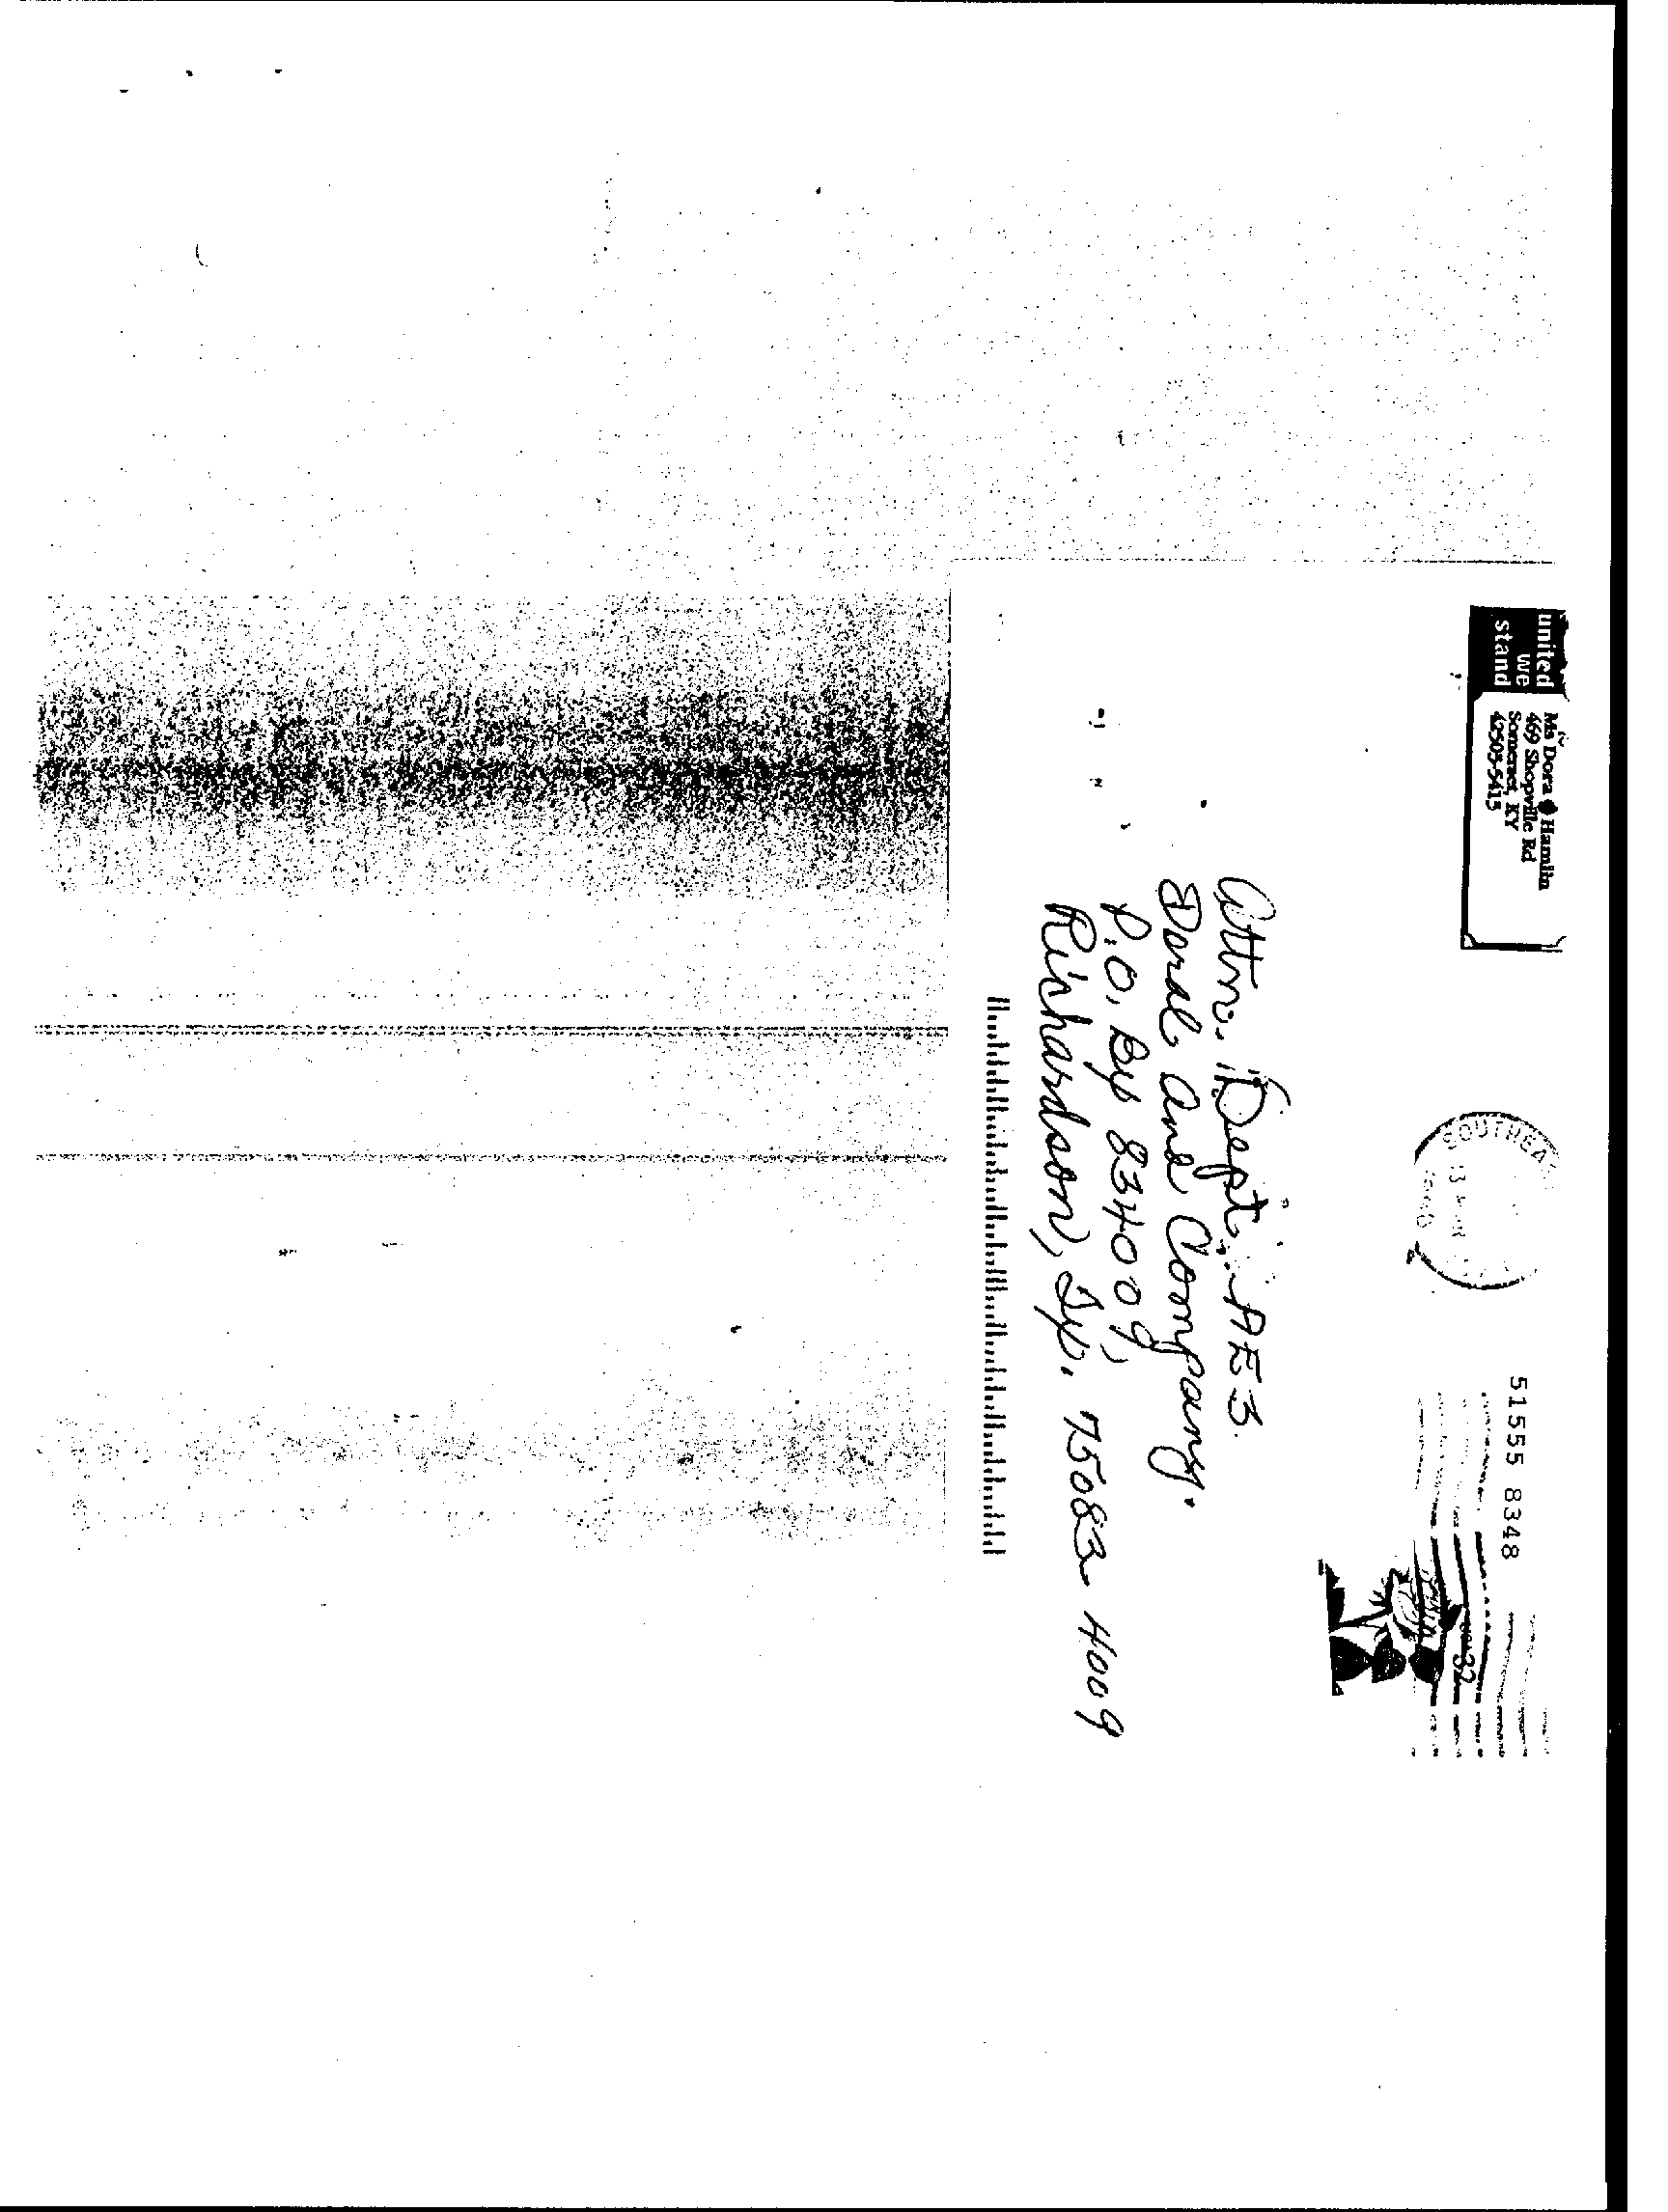

In [34]:
ocr_insight(train_short_ocrs.index[1])


<span style="color:blue">**Analyse :**</span>
- OCR inexploitable (aucune information captée du fait de l'écriture manuscrite)
- nombre de pages (2)  difficile à interpréter (le document ne semble en contenir qu'une)
- le nombre de page est un artéfact de la numérisation ==> a supprimer car ce n'est pas une information provenant du document


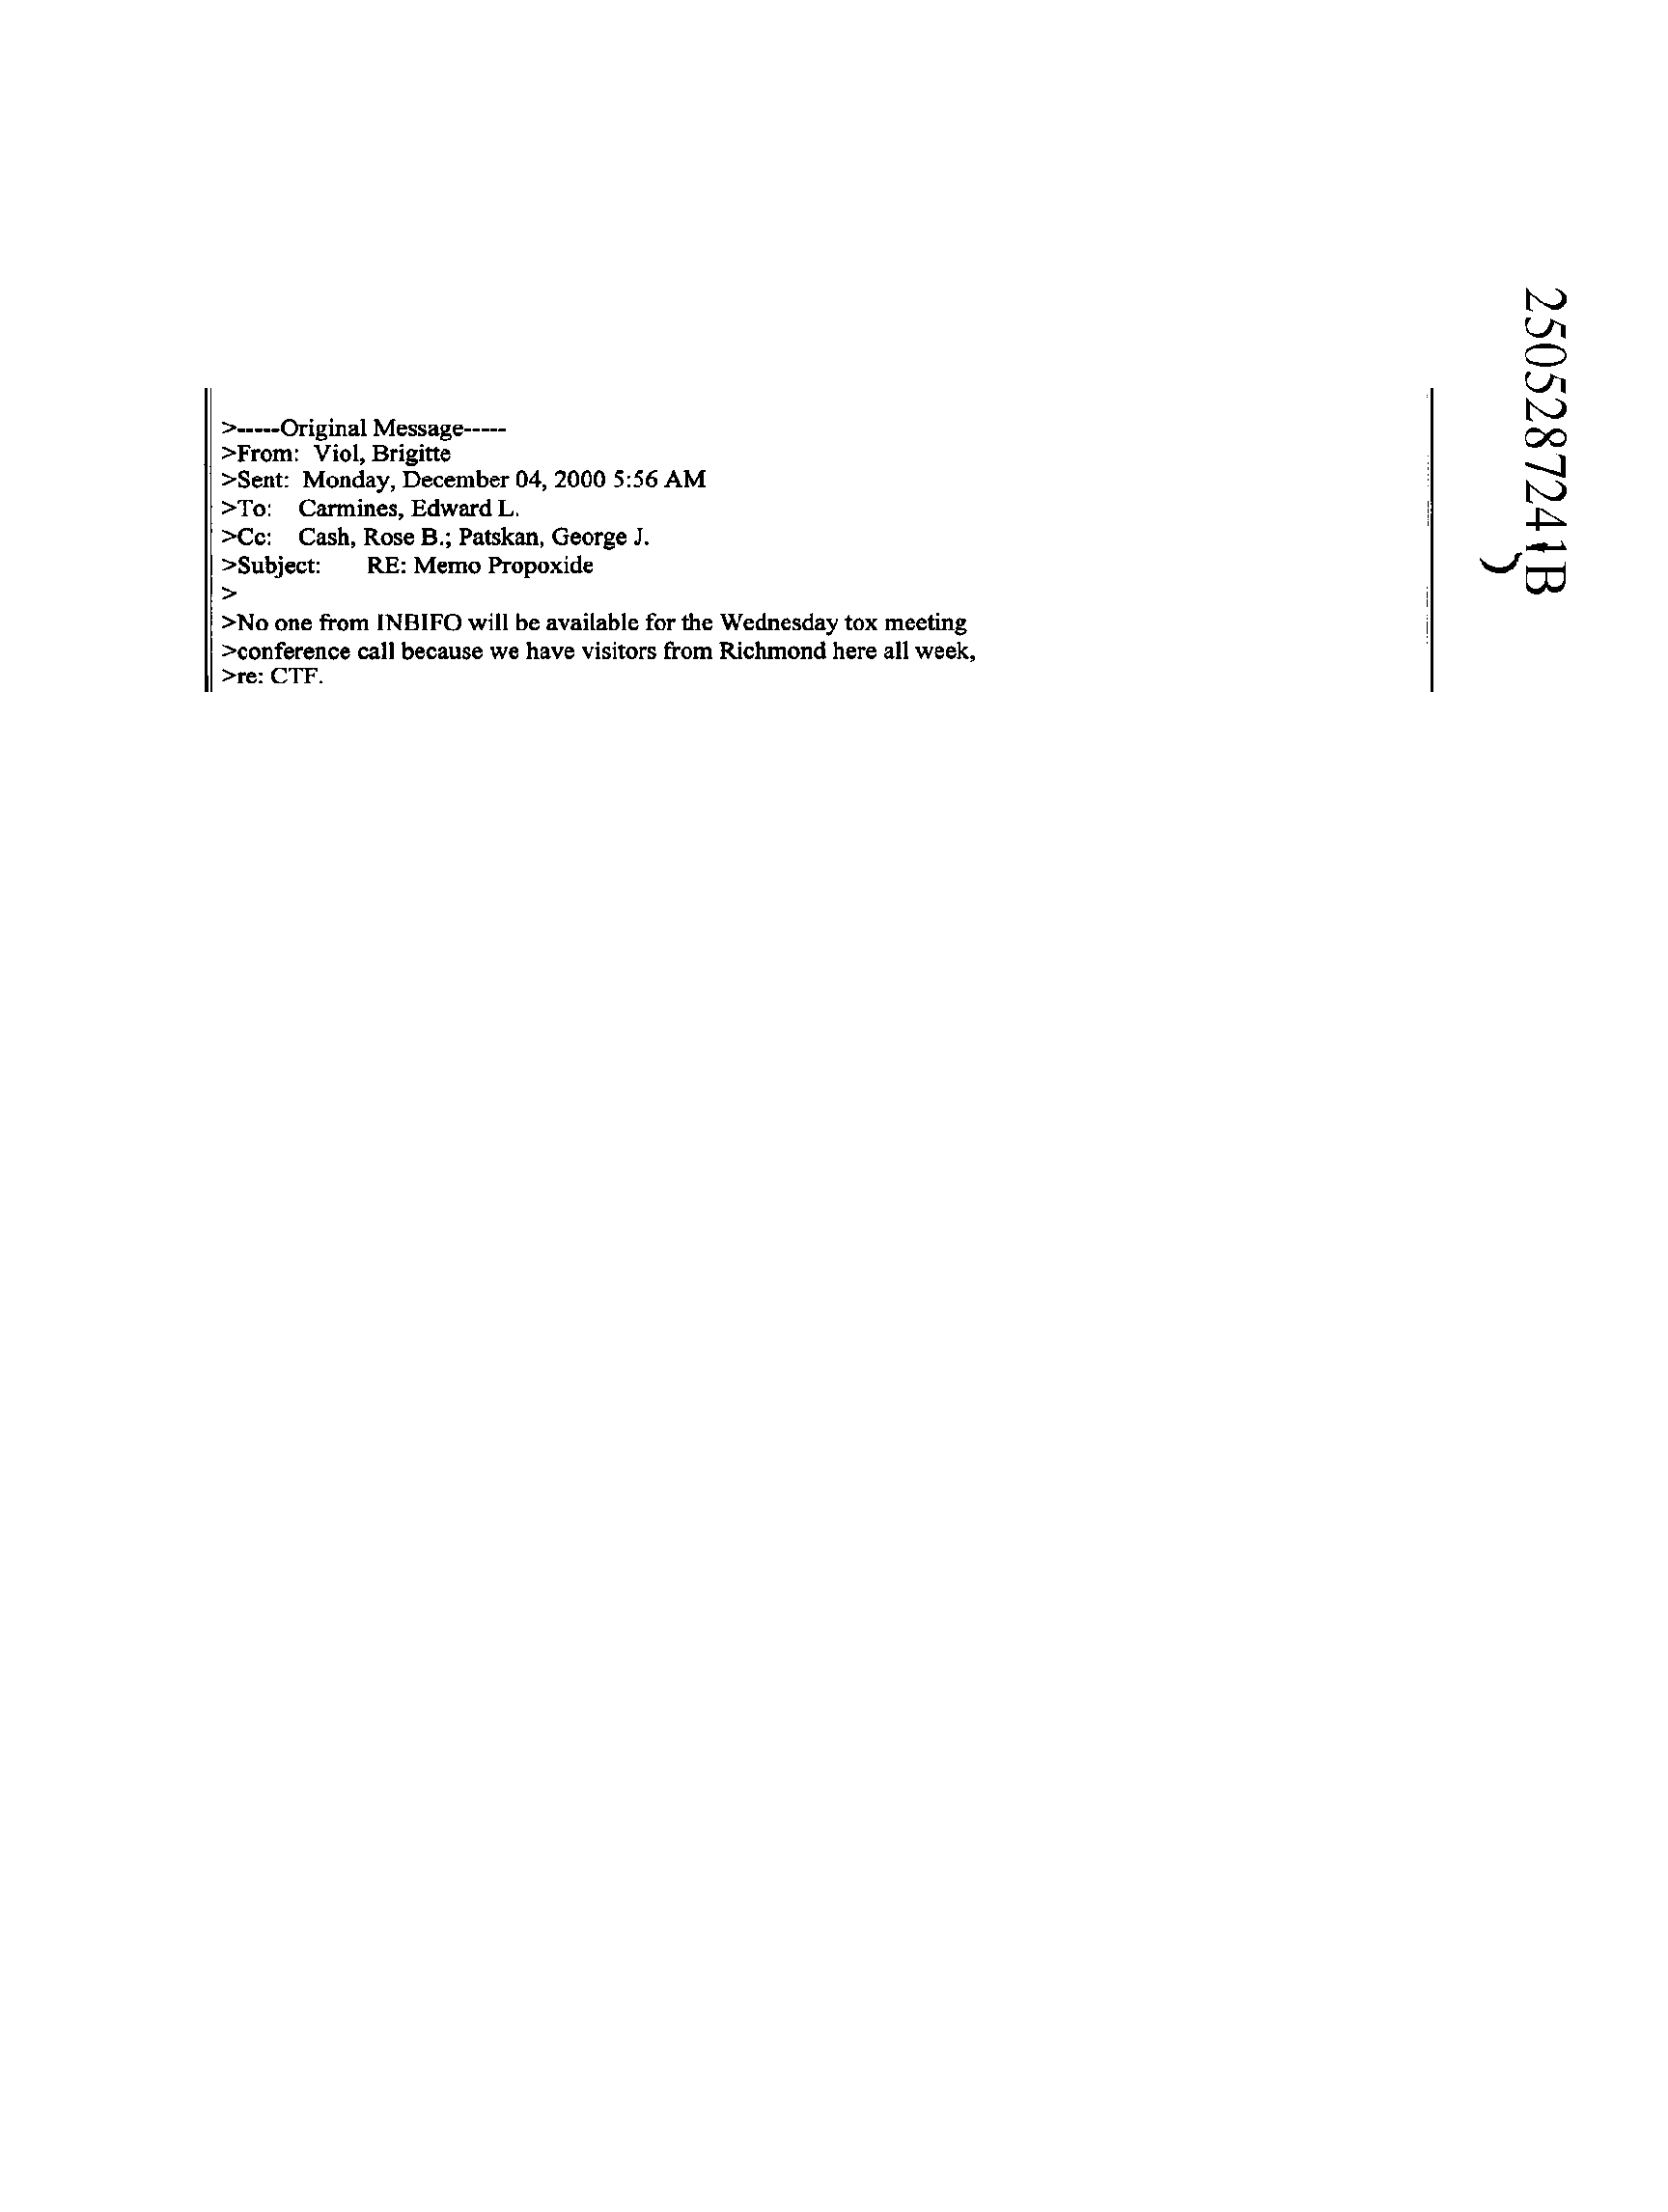

In [35]:
ocr_insight(train_short_ocrs.index[2])


<span style="color:blue">**Analyse :**</span>
- OCR parfait (hors pgNbr)


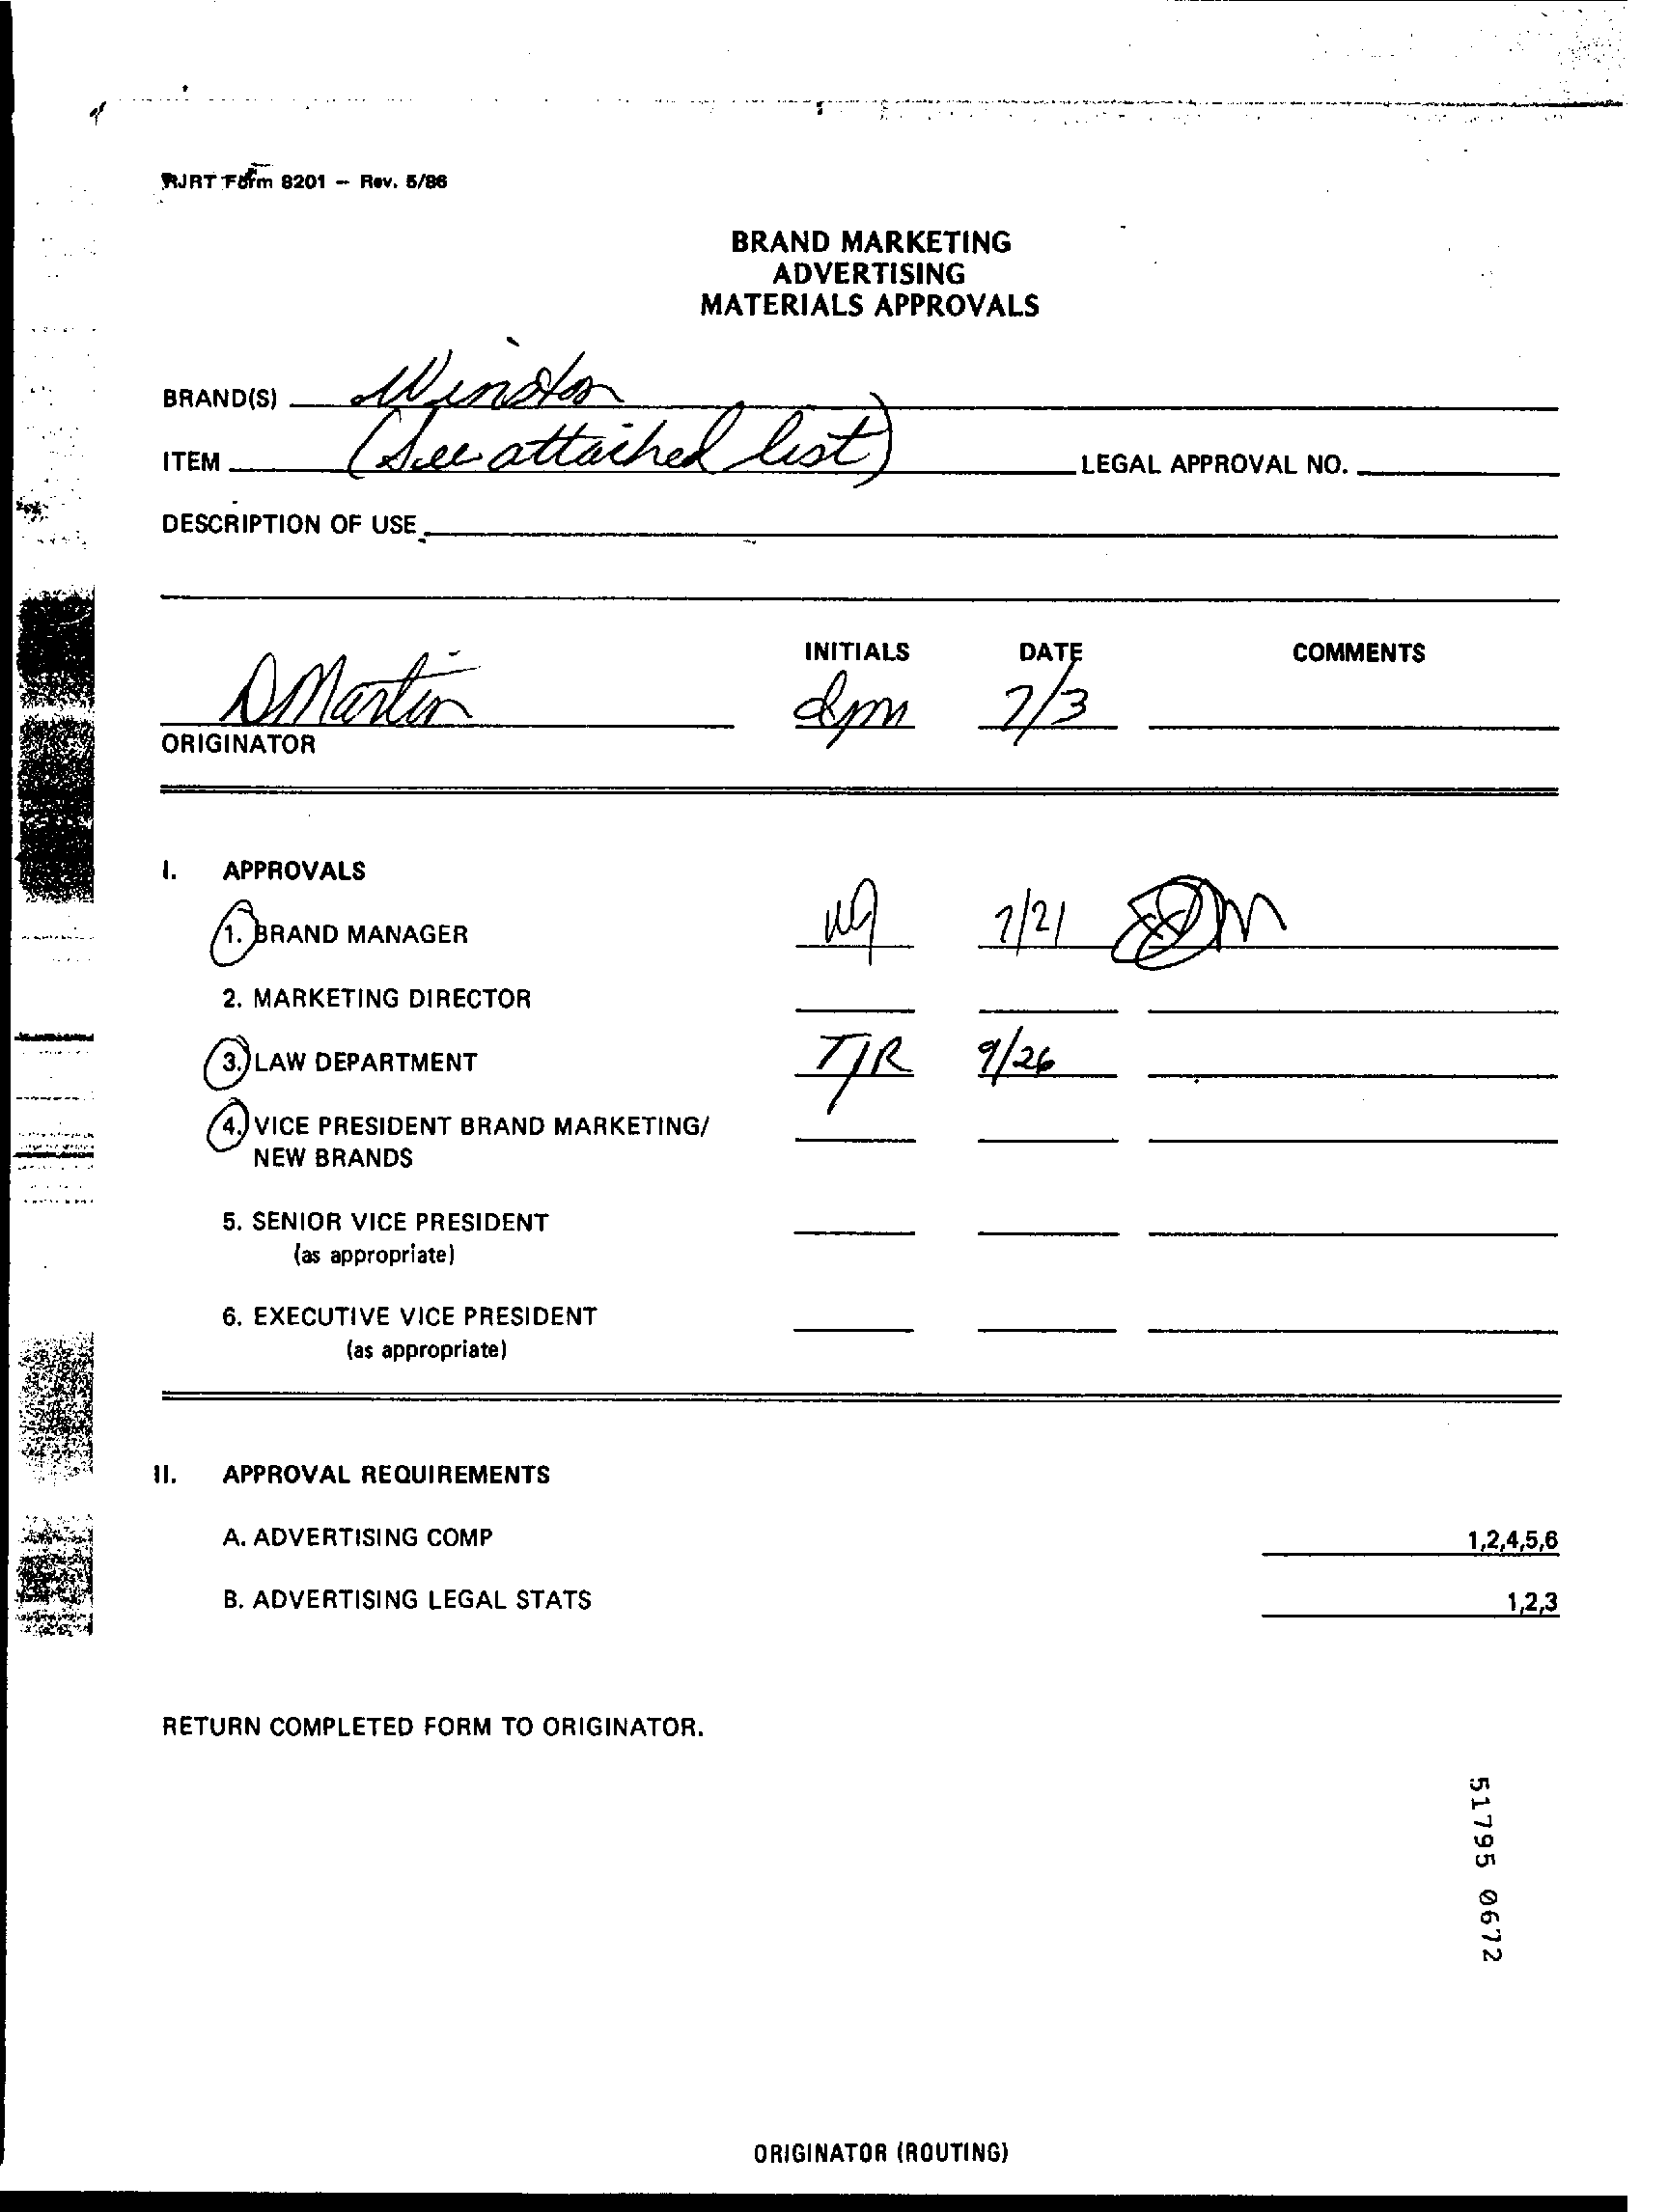

In [36]:
ocr_insight(train_short_ocrs.index[3])


<span style="color:blue">**Analyse :**</span>
- OCR globalement bon (perturbation sur les taches et manques de précision: "Rw" pour "Rev",...
- texte manuscrit ignorées
- ordre de lecture naturel non respecté (pour le tableau approvals, on parcourt la premiere colonne jusq'a 3 puis les entetes de colonne, puis la suite de la premiere colonne
- artéfact "f li"
- toujours le pgNbr


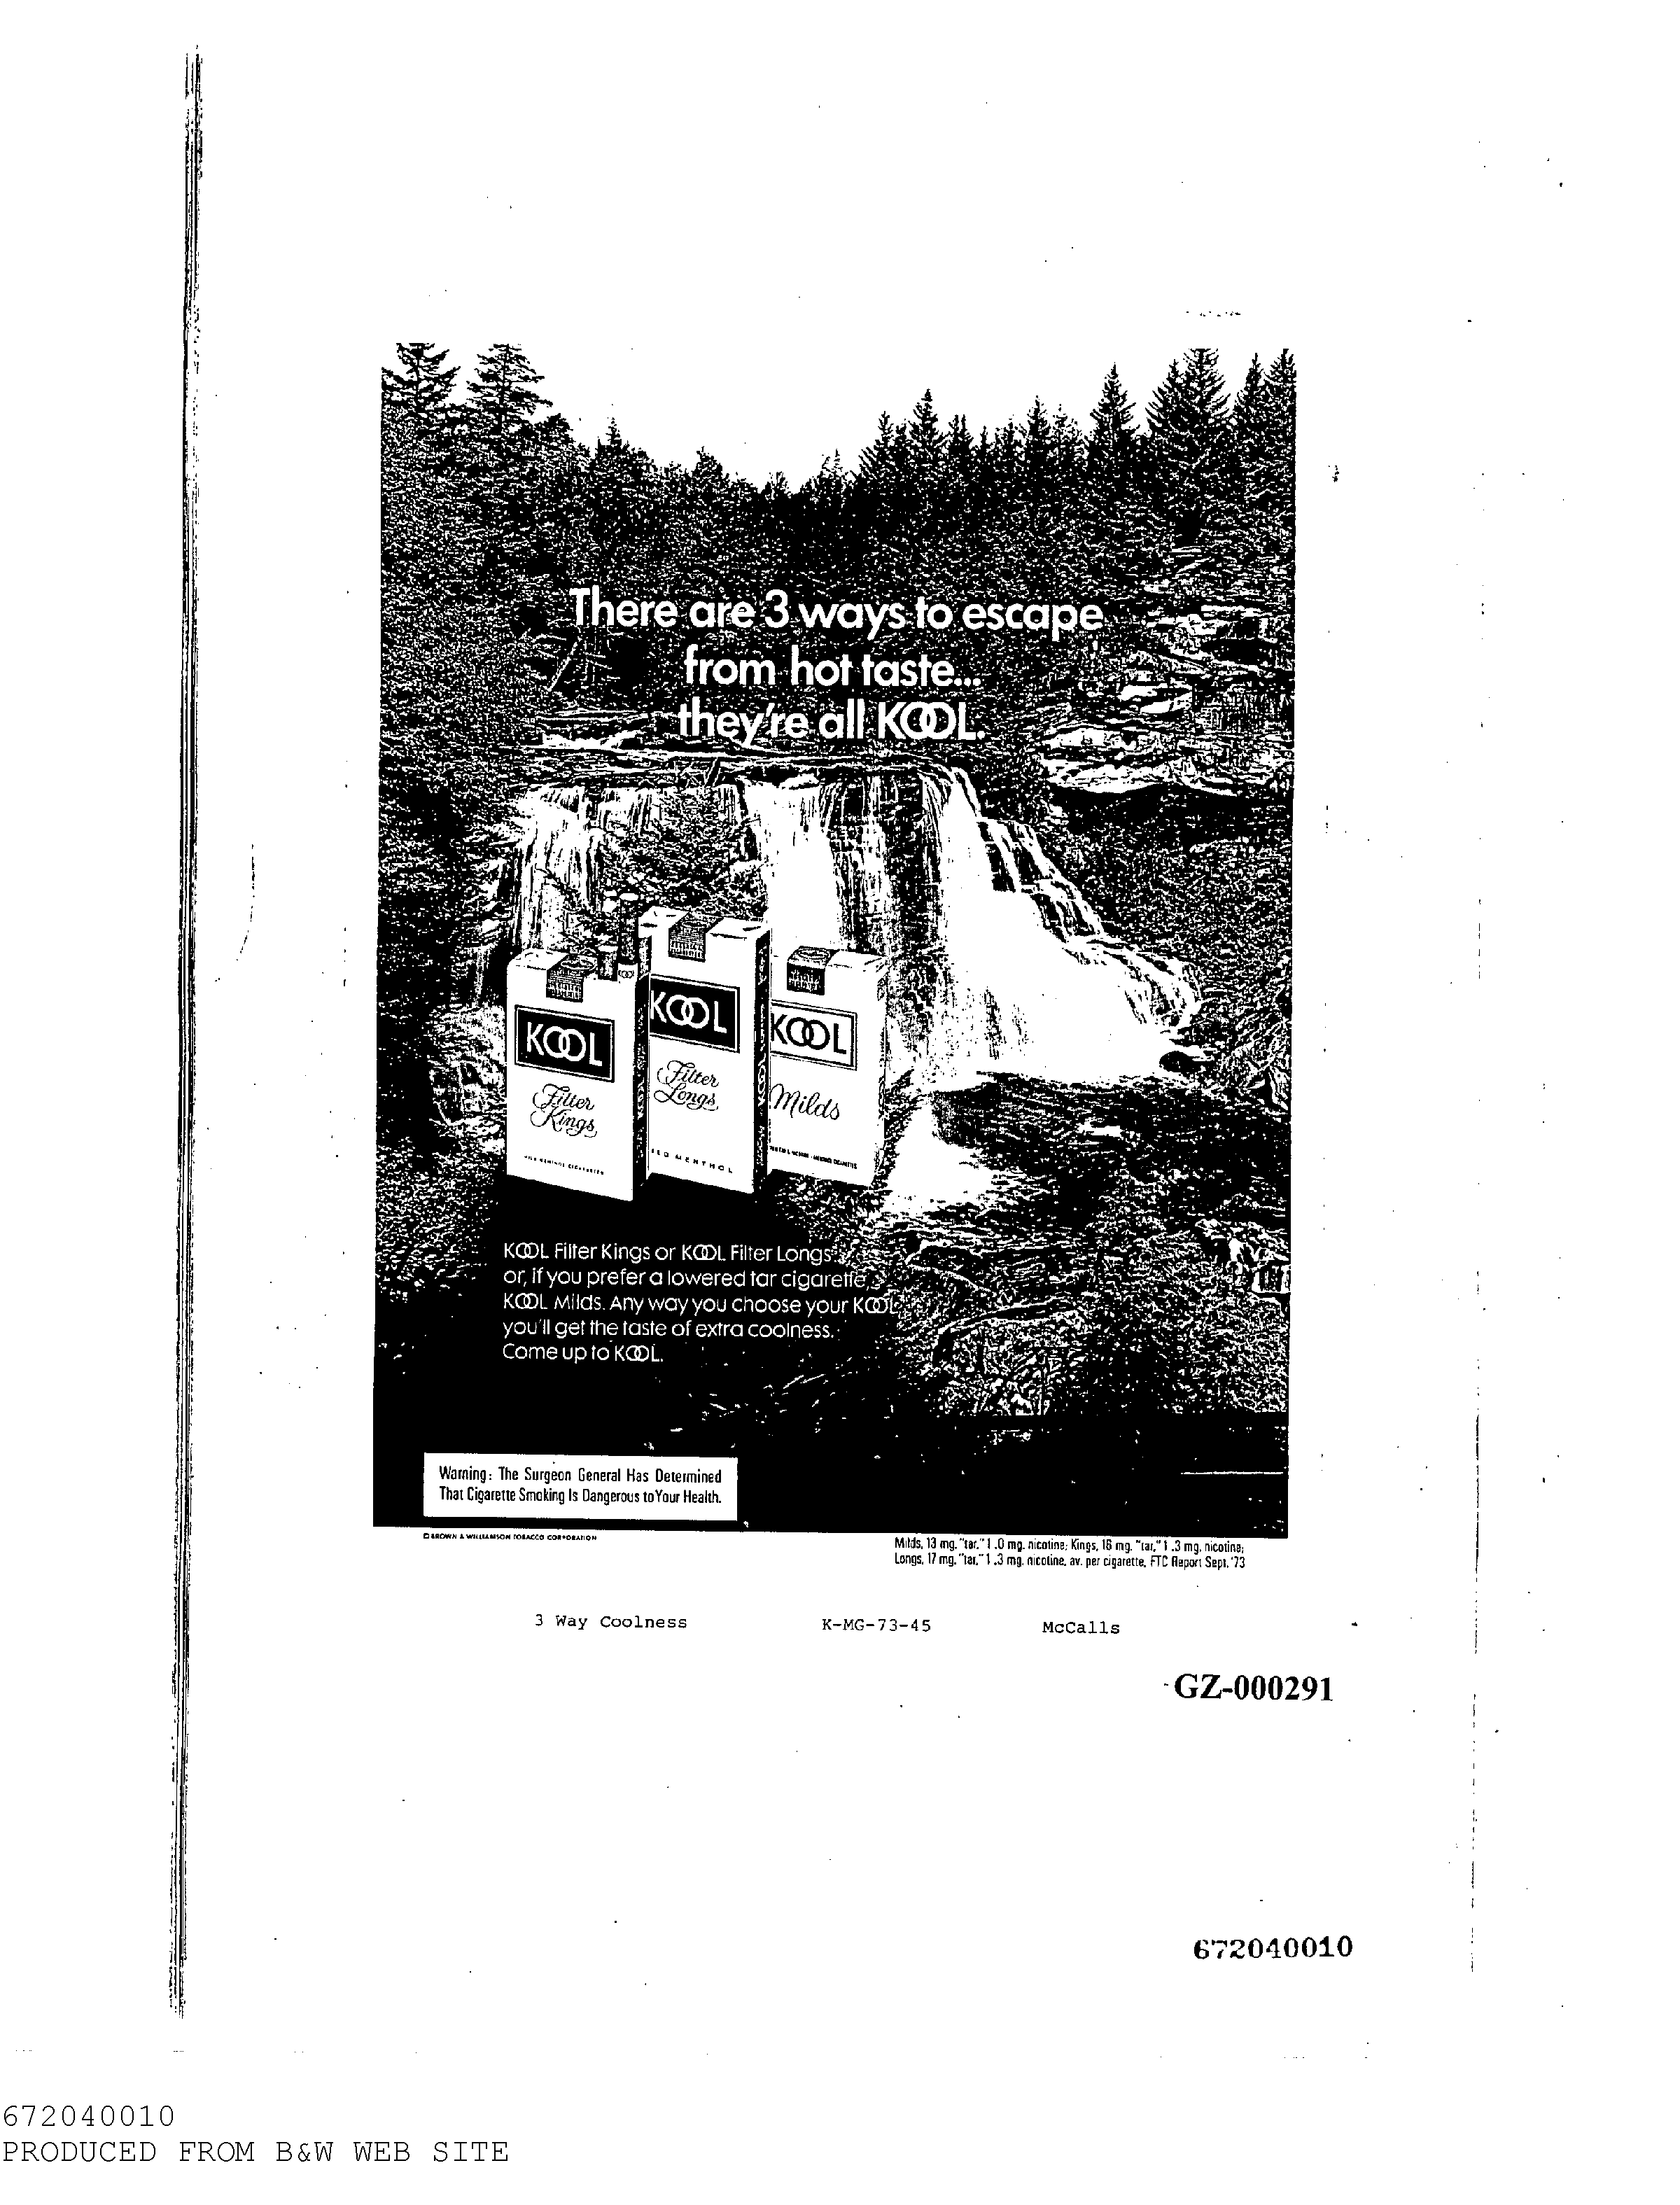

In [37]:
ocr_insight(train_short_ocrs.index[4])


<span style="color:blue">**Analyse :**</span>
- non détection du texte blanc sur fond noir
- non détection du texte dans l'encart en bas à gauche (comme si un traitement par lignesavait choisi de ne pas le traiter)
- assez peu de mauvaises détections
- textes du bas souffrant d'erreurs: nicmine pour nicotine, mdds pour milds, rigarette pour cigarette
- toujours le pgNbr

## Conclusion
Pour les traitements à venir, nous avons observé qu'il pourrait être utile:
- retirer toutes les informations relatives au pgNbr=x;
- "déséchapper" tous les caractères html (&lt, &amp, ...) // non vu ici mais est facilement identifié avec train[train.raw_ocr.str.contains("&lt")]
- corriger avec un outil spécialisé les erreurs d'océrisation, avec si possible prise en compte du contexte;
- ne pas espérer avoir de résultats sur les textes écrits à la main
- de supprimer les caractères spéciaux, voire les lignes contenant plus de ces caractères erronés que de caractères alphanumériques;
- de conserver aussi longtemps que possible les lignes, qui sont en général cohérentes;
- de considérer, in fine comme na les documents qui ne contiennent plus assez d'information (nombre de mots trop faible)

# 3. Vérification d'hypothèses

## 3.1. Isolement des "Handwritten" par un pattern spécifique
On a remarqué que les ocr correspondant à des handwritten étaient souvent formés de la même manière. Nous allons essayer de trouver un pattern qui permette de les isoler avec un bon score d'accuracy.
Nous travaillons sur le jeu de données train, pour éviter toute fuite de données.

In [39]:
df_hw_train = df[(df.label == 3) & (df.data_set == "train")]
df_others_train = df[(df.label != 3) & (df.data_set == "train")]

In [53]:
df_hw_train

,raw_ocr,label,data_set
document_id,,,
aaa11d00,"a\n`..~.:r'\n\npgNbr=1\n~ ~ Vt+~/`rr\n_.,\na\n...",3,train
aaa13d00,-4~&amp;4\n9~j~ 6~ 6/ 90 ~a\n33 39 /o\n3i-3y 3...,3,train
aaa90d00,"y P /G ~ ""I'1,11111 I,IIll g,ll 11,11,\n\npwo~...",3,train
aab60d00,LLZS TSLLS\n\npgNbr=1\ncz ~&gt;io-z~\n\n\npgNbr=2,3,train
aab90d00,"~Q4\n`\nAre- Z7/a,:2-\nL,3,fl,ff\n\npgNbr=1\nl...",3,train
...,...,...,...
zzx21d00,"lUG-27-97 Li'F9 I:61 PM t, B, SM] T8\nJ1~1e~\n...",3,train
zzx70d00,"a\nI z~~- 4rl\n--\n,\nJof y`d ~--\n\npgNbr=1",3,train
zzx72d00,MARVIS7ALIQUOR\nFax : 619-753-1065 Oct 09 14:4...,3,train


In [41]:
# On va verifier combien de documents contiennent plus de 5 mots de deux lettres.

In [42]:
import re

# A améliorer pour prendre en compte les lignes
# sans doute trop brutal / il faudra le réviser sur d'autres versions ultérieures?
def basic_word_filter(text):
    if not text:
        return text
    text = text.lower()
    # Attention, c'est brutal, ca supprime tous les chiffres aussi...
    word_regex = re.compile(r'[a-z]{4,}')
    text = ' '.join(word_regex.findall(text))
    
    return text

In [43]:
def word_count(text):
    words = text.split(' ')
    return len(words)
    
text = "pgnbr vt rr zlle am ln oajl amp pgnbr"

In [46]:
wc_results = train.raw_ocr.apply(basic_word_filter).apply(word_count)

In [49]:
df_hw_train[df_hw_train.raw_ocr.apply(basic_word_filter).apply(word_count) <10]

,raw_ocr,label,data_set
document_id,,,
aaa11d00,"a\n`..~.:r'\n\npgNbr=1\n~ ~ Vt+~/`rr\n_.,\na\n...",3,train
aaa90d00,"y P /G ~ ""I'1,11111 I,IIll g,ll 11,11,\n\npwo~...",3,train
aab60d00,LLZS TSLLS\n\npgNbr=1\ncz ~&gt;io-z~\n\n\npgNbr=2,3,train
aab90d00,"~Q4\n`\nAre- Z7/a,:2-\nL,3,fl,ff\n\npgNbr=1\nl...",3,train
aac65d00,"]1Ja IL~ ~'~~* L~\n\n3~_ !fI.: - .\n,\nFF,/tit...",3,train
...,...,...,...
zzo21d00,THE ALAN FIKES\n704 Barry Avenue\nMuscai; ;{ !...,3,train
zzp21d00,",01P J. Reymoc,os -7.- o wo d,.\nN\n-,~7/OZ m\...",3,train
zzp40d00,"~\n\npgNbr=1\n,\n\n;\ni4 s r~ ~\nit L F'\n0 Ir...",3,train


In [50]:
df_others_train[df_others_train.raw_ocr.apply(basic_word_filter).apply(word_count) <10]

,raw_ocr,label,data_set
document_id,,,
aab15c00,"""0 04 st an fe\n\nELA _\nNovember 1996 Chron\n\n",8,train
aab47c00,Jan\n01\n15\nJan-\n29\nJan-\n12\nFeb-\n26\nFeb...,12,train
aab80c00,"xow 100's #i20\nTime 9/20/82\nLTS, Inc.\nAdvcr...",4,train
aab99e00,5 9\n3 { ~7353\nI;}i~]ifj~Saja~~7lda~yffFff~lf...,7,train
aac05f00,N\nO\nO\nQ\npgNbr=1,8,train
...,...,...,...
zzx33e00,ae\n,8,train
zzy05c00,CERTIFICATIONS\n2076734459\n\npgNbr=1,8,train
zzy30e00,@\nJI\nfm)\n=)\nG3\n©\nio)\nI\n\n‘SURGEON GENE...,4,train


In [51]:
len(df_others_train)

299966

In [ ]:
# Avec un filtre à 10 mots, on arrive a identifier environ 11500 handwritten sur 20000
# dans le même temps, on identifierait à tort près de 28000 documents sur 300000
# Ce filtrage trivial n'est pas conservé

# Cette piste n'est pas concluante. Nous en restons là.